# Creating a basis using a Python functor with pyEXP

This example uses the `Cylindrical` basis made by the a user provided Python density target


In [1]:
import os
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt

# Change to the working directory containing the basis cache file.  
# We assume that you launched your Jupyter server in the Tutorials directory and supply sample data
# for these tutorials in the Data directory
#
os.chdir('../Data')

# Your current directory
!pwd

/home/weinberg/Projects/pyEXP-examples/Tutorials/Data


## Making the biorthogonal basis instances for the halo and disk

In [2]:
# Make the disk basis config
#
disk_config = """
---
id: cylinder
parameters:
  acyl: 0.01       # The scale length of the exponential disk
  hcyl: 0.002      # The scale height of the exponential disk
  lmaxfid: 32      # The maximum spherical harmonic order for the input basis
  nmaxfid: 32      # The radial order for the input spherical basis
  mmax: 6          # The maximum azimuthal order for the cylindrical basis
  nmax: 12         # The maximum radial order of the cylindrical basis
  ncylnx: 256      # The number of grid points in mapped cylindrical radius
  ncylny: 128      # The number of grid points in mapped verical scale
  ncylodd: 3       # The number of anti-symmetric radial basis functions per azimuthal order m
  rnum: 1000       # The number of radial integration knots in the inner product
  pnum: 0          # The number of azimuthal integration knots (pnum: 0, assume axisymmetric target density)
  tnum: 80         # The number of colatitute integration knots
  ashift: 0.5      # Target shift length in scale lengths to create more variance
  vflag: 16        # Verbosity flag: print diagnostics to stdout for vflag>0
  logr: false      # Log scaling in cylindrical radius
  dtype: python    # Use user-supplied python module
  pyname: pyDens   # The module name
  cachename: eof.cache.runPy  # The cache file name
...
"""


We need a density function in the working directory or in your `PYTHONPATH` called "disk_density" with arguments $(R, z, \phi)$ that is called `pyDens.py`.  Here is a simple example:

In [3]:
with open('pyDens.py', 'w') as f:
    f.write(
R"""
import math

# Gaussian blob density
def disk_density(R, z, phi):
    a = 0.01                      # Scale radius
    h = 0.002                     # Scale height
    f = R*math.exp(-R*R/(a*a))
    g = math.exp(-z*z/(h*h))
    return f * g;
"""
    )

## Construct the basis

Now we can construct the basis instance from this config and the EOF cache file produced by `cylcache`.  If you have not run `cylcache` and/or the file does not exist, the following call with construct it.

In [4]:
# Construct the basis instance
#
disk_basis = pyEXP.basis.Basis.factory(disk_config)

---- EmpCylSL::ReadH5Cache: read <eof.cache.runPy>
---- EmpCylSL::read_cache: table forwarded to all processes
---- Cylindrical::orthoTest: worst=0.00023113


Worker    0: tables allocated, MMAX=6


Look into the cache file

In [5]:
node_cyl = disk_basis.cacheInfo('eof.cache.runPy')

------------------------------------------------------------
Cache parameters for EmpCylSL: eof.cache.runPy
------------------------------------------------------------
mmax                : 6
numx                : 256
numy                : 128
lmaxfid             : 32
nmaxfid             : 32
nmax                : 12
neven               : 9
nodd                : 3
cmapr               : 1
cmapz               : 1
rmin                : 0.001
rmax                : 20
ascl                : 0.01
hscl                : 0.002
cmass               : 0
------------------------------------------------------------


## Viewing some basis functions
The `getBasis` member for each basis returns a vectors of arrays for the basis functions on the grid you have defined.  See the following examples.

In [6]:
# Get the basis grid
#
Rmin = 0.0
Rmax = 0.06
Rnum = 100
Zmin = -0.02
Zmax =  0.02
Znum = 40

disk_grid = disk_basis.getBasis(Rmin, Rmax, Rnum, Zmin, Zmax, Znum)

The cylindrical basis are two-dimensional merional planes.   We'll use `contourf` for those.

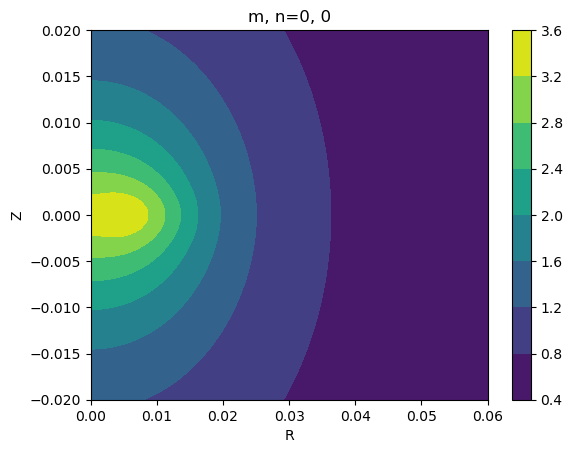

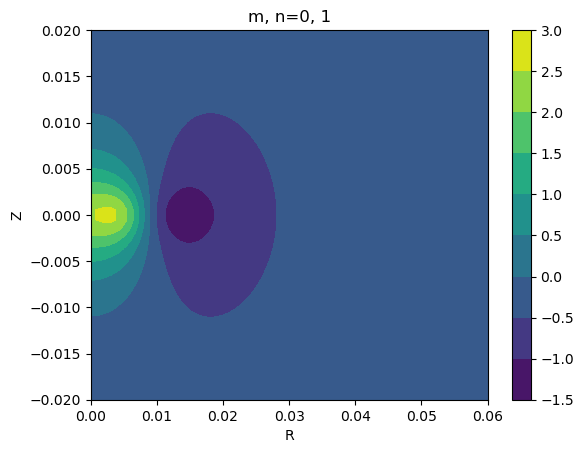

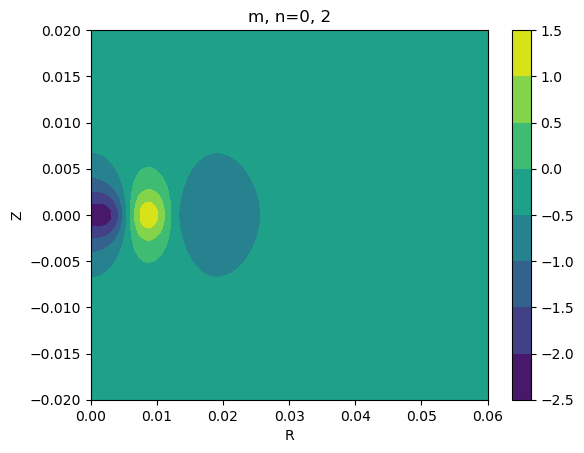

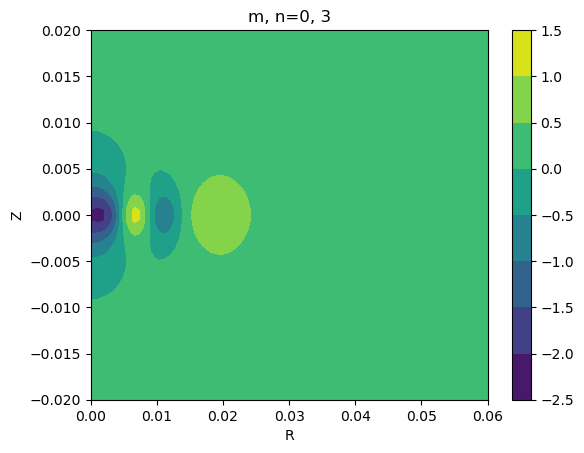

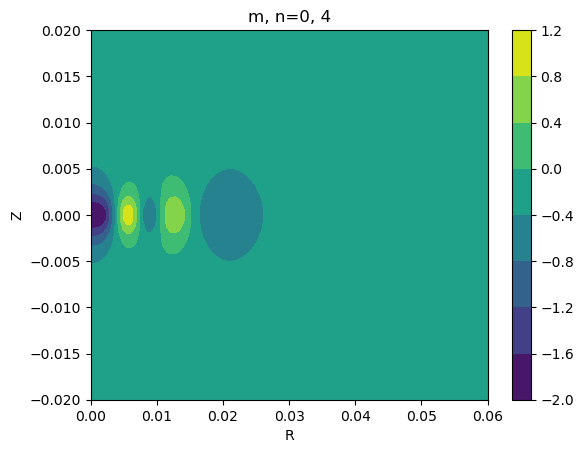

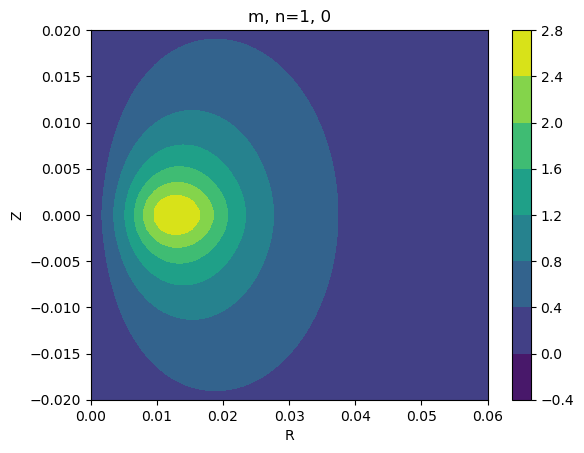

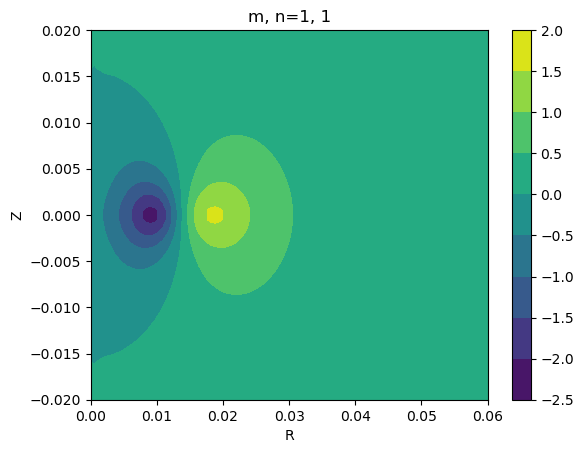

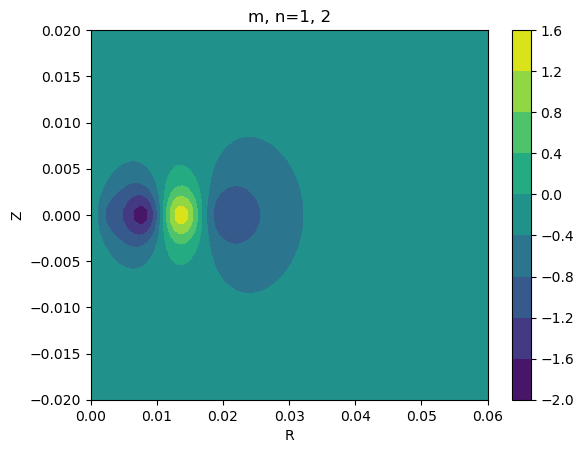

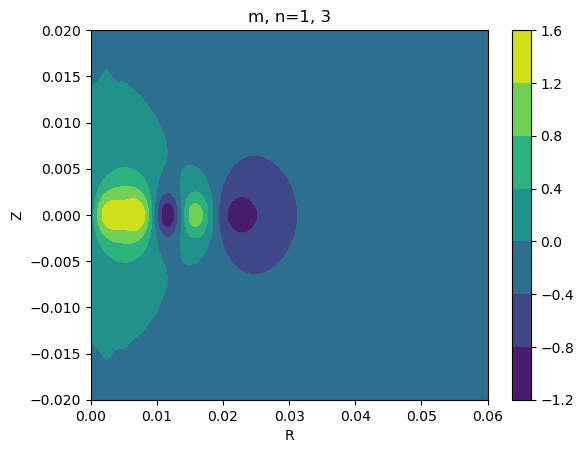

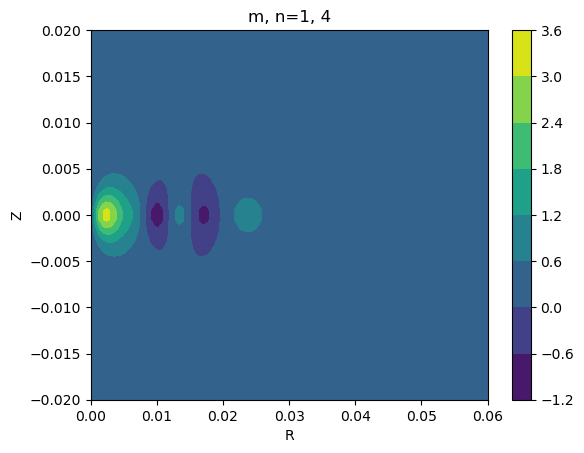

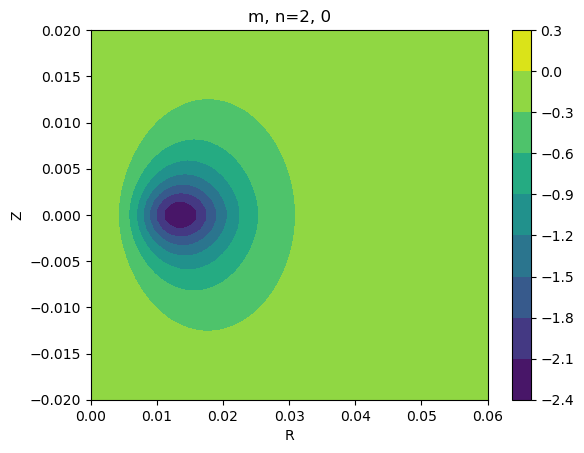

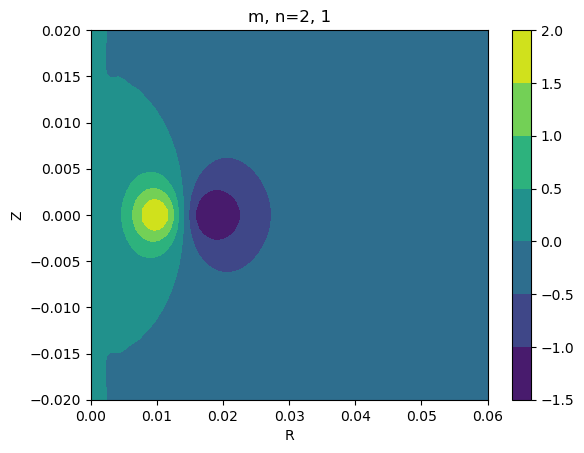

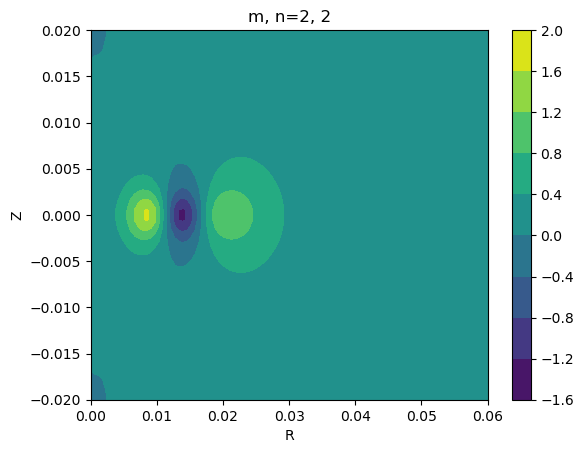

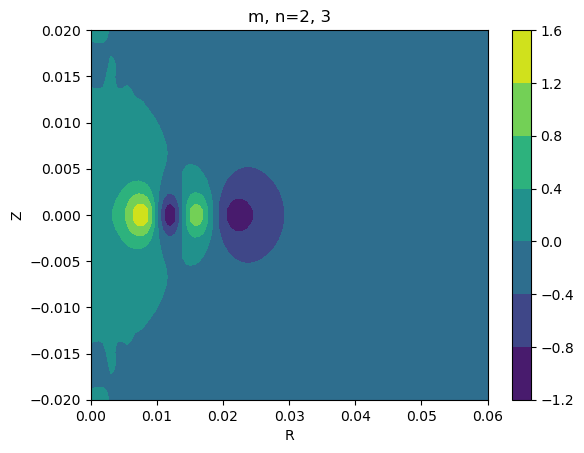

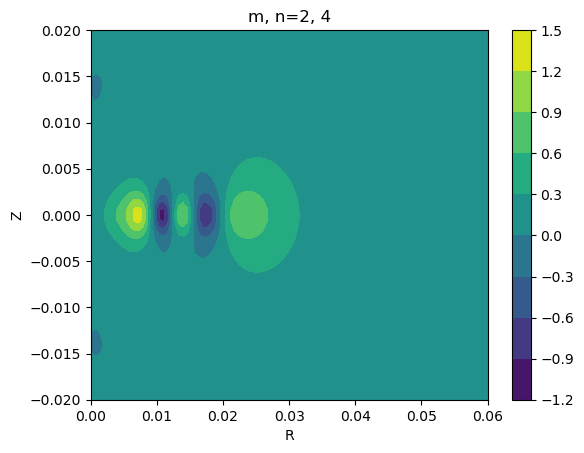

In [7]:
R = np.linspace(Rmin, Rmax, Rnum)
Z = np.linspace(Zmin, Zmax, Znum)

xv, yv = np.meshgrid(R, Z)

for m in range(3):
    for n in range(5):
        # Tranpose for contourf
        cx = plt.contourf(xv, yv, disk_grid[m][n]['potential'].transpose())
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.title('m, n={}, {}'.format(m, n))
        plt.colorbar(cx)
        plt.show()
    

The `disk_config` above specifies `nmax: 8` and `noddcyl: 3`.  This creates a cylindrical basis with 5 vertically symmetric basis functions, and 3 vertically anti-symmetric basis functions.  The symmetric basis functions have indices [0,...,4] and the anti-symmetric basis functions have indices [5,6,7].

So the plots above show the first 5 symmetric basis functions.  We quickly modify this code to visualize the antisymmetric functions:

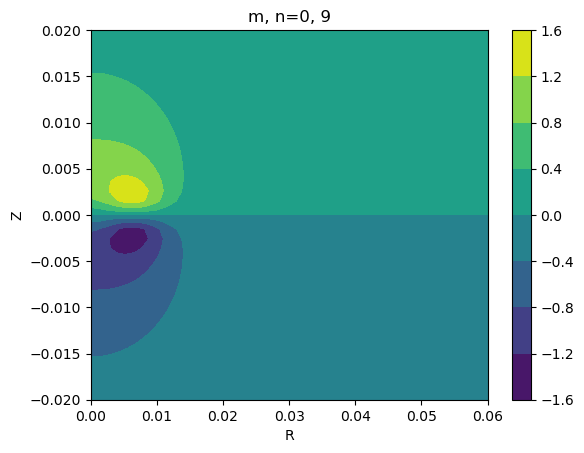

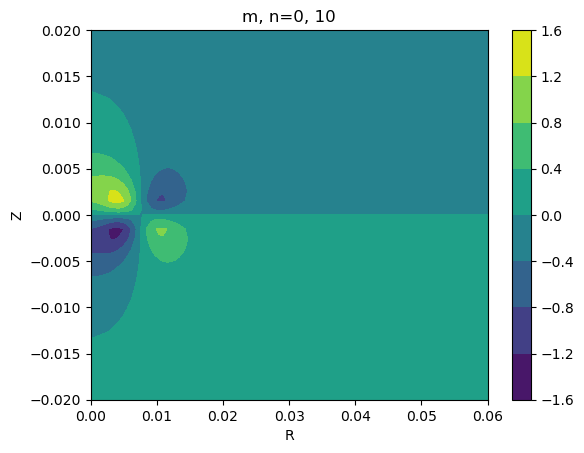

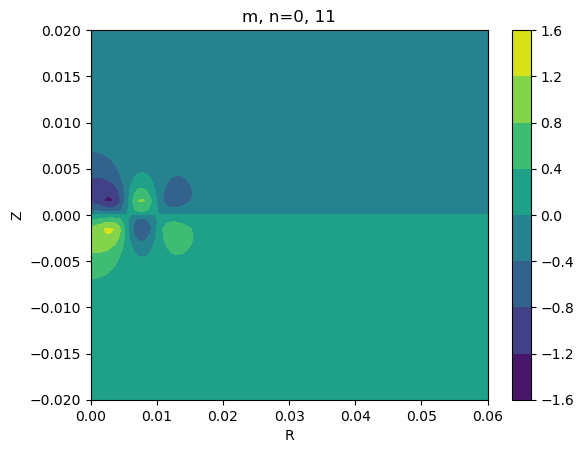

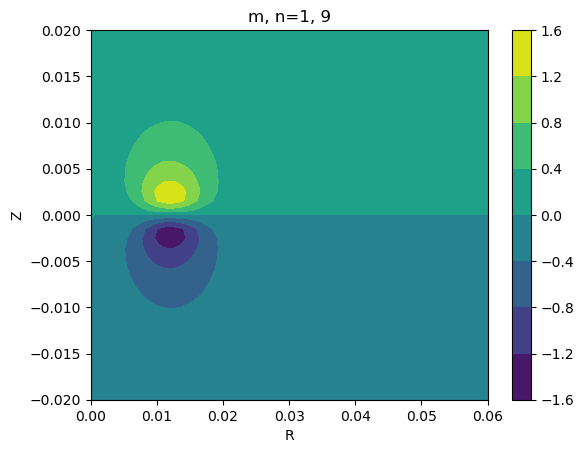

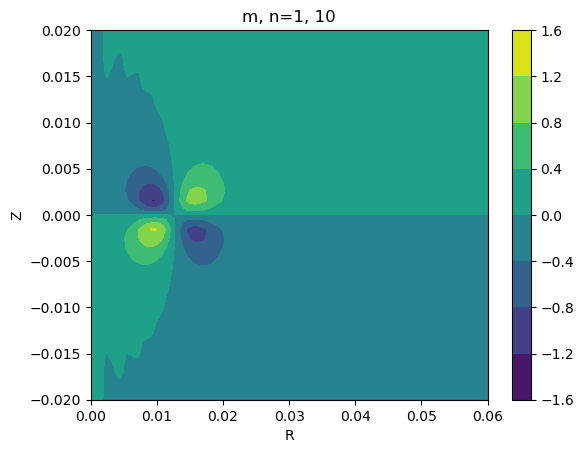

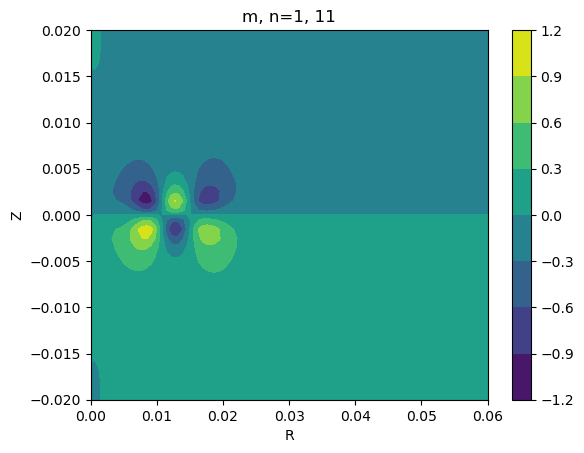

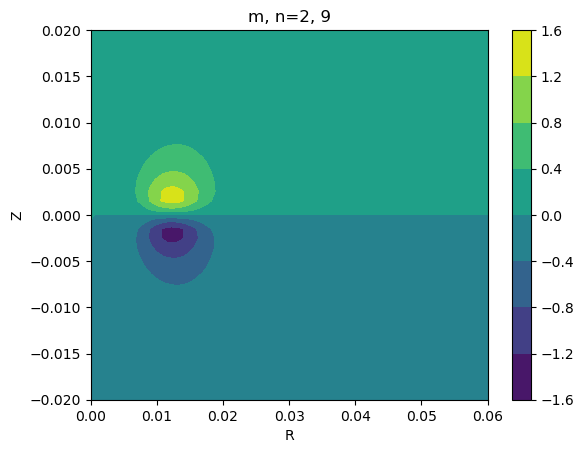

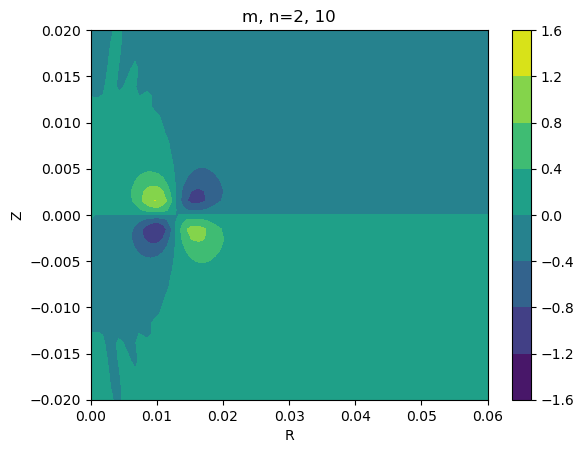

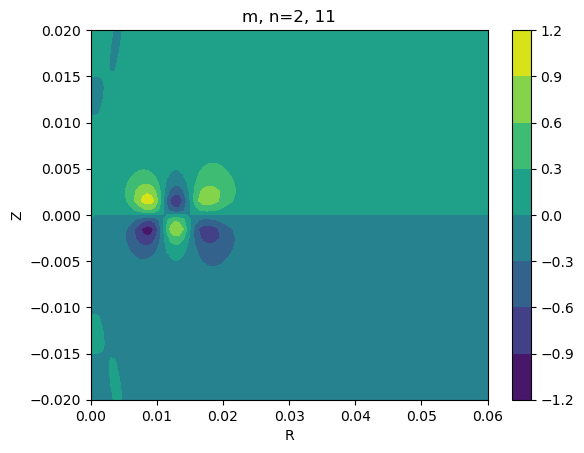

In [8]:
for m in range(3):
    for n in range(9, 12):
        # Tranpose for contourf
        cx = plt.contourf(xv, yv, disk_grid[m][n]['potential'].transpose())
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.title('m, n={}, {}'.format(m, n))
        plt.colorbar(cx)
        plt.show()
    